# BentoML Example: Fast AI Pet Image classification  


**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.

Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.


This example notebook is based on Fast AI v1 course v3 lesson one, training an image classifier with Fast AI that detect the different breed of cat and dog.


Make sure to __use GPU runtime when running this notebook in Google Colab__, you can set it in top menu: `Runtime > Change Runtime Type > Hardware accelerator`.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=fast-ai&ea=fast-ai-pet-image-classification&dt=fast-ai-pet-image-classification)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -q bentoml 'fastai<=1.0.61'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Prepare Training Data

In [3]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg')]

In [5]:
#bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

data = ImageDataBunch.from_name_re(
    path_img,
    fnames,
    pat,
    num_workers=0,
    ds_tfms=get_transforms(),
    size=224,
    bs=bs
).normalize(imagenet_stats)

/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("Th

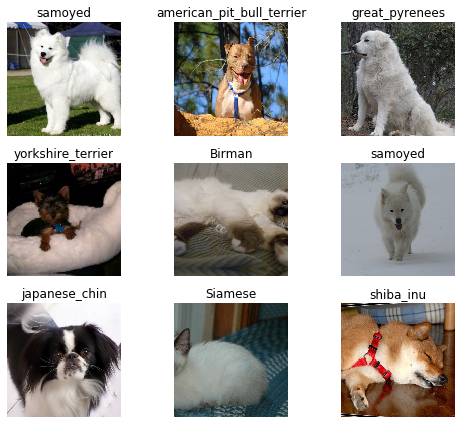

In [6]:
data.show_batch(rows=3, figsize=(7,6))

## Training: resnet34

Now we will start training the model. For demo purpose, we will only train for 1 epoch (1 cycle through all the data).

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [8]:
learn.fit_one_cycle(1)

/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("Th

## Create BentoService for model serving

In [9]:
%%writefile pet_classification.py

from bentoml import BentoService, api, env, artifacts
from bentoml.frameworks.fastai import Fastai1ModelArtifact
from bentoml.adapters import ImageInput
from fastai.vision import Image, pil2tensor
import numpy as np

@env(pip_packages=['fastai'])
@artifacts([Fastai1ModelArtifact('pet_classifer')])
class PetClassification(BentoService):
    
    @api(input=ImageInput(), batch=False)
    def predict(self, image):
        fastai_image = pil2tensor(image, np.float32)
        fastai_image = Image(fastai_image)
        result = self.artifacts.pet_classifer.predict(image)
        return str(result)

Overwriting pet_classification.py


## Save BentoService to file archive

In [10]:
# 1) import the custom BentoService defined above
from pet_classification import PetClassification

# 2) `pack` it with required artifacts
service = PetClassification()
service.pack('pet_classifer', learn)

# 3) save your BentoSerivce
saved_path = service.save()

[2020-09-22 17:49:00,048] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 17:49:00,214] INFO - Using default docker base image: `None` specified inBentoML config file or env var. User must make sure that the docker base image either has Python 3.7 or conda installed.
[2020-09-22 17:49:00,218] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2020-09-22 17:49:00,221] WARNING - pip package requirement fastai already exist
[2020-09-22 17:49:01,625] INFO - Detected non-PyPI-released BentoML installed, copying 

/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/setuptools/dist.py:476: UserWarning: Normalizing '0.9.0.pre+3.gcebf2015' to '0.9.0rc0+3.gcebf2015'
  normalized_version,
no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.9.0rc0+3.gcebf2015/bentoml/_version.py
set BentoML-0.9.0rc0+3.gcebf2015/bentoml/_version.py to '0.9.0.pre+3.gcebf2015'
[2020-09-22 17:49:05,483] INFO - BentoService bundle 'PetClassification:20200922174900_F25F3F' saved to: /Users/bozhaoyu/bentoml/repository/PetClassification/20200922174900_F25F3F


## REST API Model Serving


To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [15]:
!bentoml serve PetClassification:latest

[2020-09-22 18:05:30,874] INFO - Getting latest version PetClassification:20200922174900_F25F3F
[2020-09-22 18:05:30,875] INFO - Starting BentoML API server in development mode..
[2020-09-22 18:05:31,124] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 18:05:31,139] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+3.gcebf2015
[2020-09-22 18:05:34,809] INFO - Using default docker base image: `None` specified inBentoML config file or env var. User must make sure that the docker base image either has Python 3.7 or conda installed.
[2020-09-22 18:05:34,925] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoM

If you are running this notebook from Google Colab, you can start the dev server with `--run-with-ngrok` option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com/):

In [ ]:
!bentoml serve PetClassification:latest --run-with-ngrok

Open http://127.0.0.1:5000 to see more information about the REST APIs server in your
browser.


### Send prediction requeset to the REST API server

Navigate to parent directory of the notebook(so you have reference to the `test.jpg` image), and run the following `curl` command to send the image to REST API server and get a prediction result:

```bash
curl -i \
    --request POST \
    --header "Content-Type: multipart/form-data" \
    -F "image=@test.jpg" \
    localhost:5000/predict
```

## Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [16]:
!bentoml containerize PetClassification:latest

[2020-09-22 18:07:15,056] INFO - Getting latest version PetClassification:20200922174900_F25F3F
Found Bento: /Users/bozhaoyu/bentoml/repository/PetClassification/20200922174900_F25F3F
[2020-09-22 18:07:15,098] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 18:07:15,114] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+3.gcebf2015
Tag not specified, using tag parsed from BentoService: 'petclassification:20200922174900_F25F3F'
Building Docker image petclassification:20200922174900_F25F3F from PetClassification:latest 
-we in here
processed docker file
(None, None)
root in create archive /Users/bozhaoyu/bentoml/repository/PetClassification/20200922174900_F25F3F ['Dockerfile', 'MAN

Start a container with the docker image built in the previous step:

In [ ]:
!docker run -p 5000:5000 PetClassification/20200122122128_513734

## Load saved BentoService

bentoml.load is the API for loading a BentoML packaged model in python:

In [12]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

[2019-09-17 15:20:59,886] WARNING - Module `pet_classification` already loaded, using existing imported module.
(Category Egyptian_Mau, tensor(5), tensor([8.1198e-05, 4.7572e-03, 8.4651e-06, 7.2410e-04, 4.4823e-04, 9.9232e-01,
        1.2686e-04, 8.9391e-06, 3.2297e-05, 2.6294e-04, 1.2570e-05, 1.7887e-04,
        2.3823e-05, 1.0635e-05, 3.7823e-06, 2.6734e-05, 4.9237e-05, 3.0513e-05,
        5.5845e-05, 7.1444e-05, 3.7852e-04, 1.9912e-05, 4.3253e-06, 2.8950e-05,
        7.1766e-06, 5.2756e-06, 1.9716e-05, 2.6185e-06, 9.0641e-05, 1.7248e-05,
        9.3070e-06, 3.1759e-05, 7.4544e-05, 1.3818e-05, 2.7183e-05, 1.8018e-05,
        1.3240e-05]))


## Launch inference job from CLI

BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [17]:
!bentoml run PetClassification:latest predict --input-file test.jpg

[2020-01-22 12:50:18,951] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.8. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-01-22 12:50:18,964] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.5.8,  but loading from BentoML version 0.5.8+23.g1dd72d3
[2020-01-22 12:50:22,038] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will b

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)
